In [2]:
from intake import open_catalog
import datetime
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import scipy.io
import gsw
import gcsfs
import xarray as xr
import rclv
from copy import deepcopy
from skimage import measure
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import cartopy.feature as cft
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='dimgrey', linewidth=0.5)

In [4]:
from dask.distributed import Client, progress
from dask_gateway import Gateway

gateway = Gateway()
cluster = gateway.new_cluster()
cluster.scale(12)
cluster

In [5]:
client = Client(cluster)
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.98e6f059a97a49f8bd3a445e5dc1ee7b Dashboard: /services/dask-gateway/clusters/prod.98e6f059a97a49f8bd3a445e5dc1ee7b/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
# load the time of eddy identification
fn = '/home/jovyan/RCLVs/SCS/Eddies_SCS_structure_olddata.mat'
data = scipy.io.loadmat(fn)

data1 = data['eds_28d_stru']
data2 = data['eds_28d_trk_stru']
data3 = data['t_eddy']

In [7]:
nyear = len(np.arange(1993, 2016, 1))
date_st = np.zeros((nyear*12,))

i = 0
for year in np.arange(1993, 2016, 1):
    for mon in np.arange(1, 13, 1):
        date_st[i] = datetime.date.toordinal(datetime.date(year, mon, 1))
        i += 1

In [8]:
# load ssh eddy information
df = pd.read_pickle('ssh_eddy.pkl')
df.head(3)

,id,date_start,date_end,duration,time,amplitude,area,radius,cyc,vorticity,boundary,center_traj,dx,speed_x,dy,speed_y,edgespd,KE
0,1,727930.0,727974.0,45.0,"[727930.0, 727931.0, 727932.0, 727933.0, 72793...","[0.11838749999999995, 0.10981249999999995, 0.0...","[49443282949.5106, 51528771071.985535, 4807651...","[125452.32468237357, 128070.75097427328, 12370...",-1,"[-5.079862108387701e-06, -3.9951094633436e-06,...","[[[124.625, 124.61302025441522, 124.4738922948...","[[123.875, 20.125], [123.625, 20.125], [123.62...",[-339318.446975324],[-0.08727326311093725],[138993.65830569842],[0.03574939771237099],"[[0.3306296818218309], [0.3109364909168646], [...","[[0.038708667733539925], [0.033498247667763804..."
1,2,727945.0,727975.0,31.0,"[727945.0, 727948.0, 727949.0, 727950.0, 72795...","[-0.006193750000000012, -0.005843749999999995,...","[5364986281.95167, 4218629684.2609034, 4532162...","[41324.6678484611, 36644.66584168355, 37981.99...",1,"[4.813249291474523e-06, 5.52552357938096e-06, ...","[[[116.125, 115.875, 115.625, 115.607487070992...","[[115.875, 11.125], [115.875, 11.375], [115.87...",[-136381.70384510676],[-0.05091909492424834],[-111194.92664455874],[-0.04151542960146309],"[[0.10353754338132873], [0.10173062220777777],...","[[0.003056260480955768], [0.003557561833914299..."
2,3,727943.0,727990.0,48.0,"[727943.0, 727944.0, 727945.0, 727946.0, 72794...","[-0.006606250000000029, -0.009631250000000015,...","[4649025713.992656, 6967506588.934885, 1071521...","[38468.56958461698, 47093.80245115778, 58401.6...",1,"[6.4026038674683805e-06, 5.528846823722682e-06...","[[[112.875, 112.93956392887384, 113.125, 113.3...","[[113.375, 11.625], [113.125, 11.375], [113.37...",[-81685.48172611221],[-0.019696537839050975],[-27798.731661139685],[-0.006703012071069561],"[[0.11627046908731815], [0.14219361701199912],...","[[0.0032280474944493486], [0.00597119645133987..."


In [9]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_aviso  = cat["sea_surface_height"].to_dask()

#### Find random 30-day and 60-day eddies

In [10]:
eddy_30_id = []
eddy_60_id = []

for i in np.arange(1, 2394, 1):
    
    eddy_time = df.time[i] # lifetime of ssh eddy

    date0_str = datetime.date.fromordinal(int(eddy_time[0]-366)).strftime('%Y-%m-%d')
    
    duration = df.duration[i]
    
    date_diff = (date_st - eddy_time[0] + 366).tolist()    # check the number!!!!!!
    
    var_tmp1 = [num for num in date_diff if num >= 0]
    
    if len(var_tmp1) > 0:
        min_diff = min(var_tmp1)
    
        remain_days = df.duration[i] - min_diff # calculate the days left
        start_day = eddy_time[0] - 366 + min_diff
        start_str = datetime.date.fromordinal(int(start_day)).strftime('%Y-%m-%d')

        sd_id = np.argwhere(eddy_time == (start_day+366))

        if sd_id.shape[0] > 0 and start_str == '2010-01-01' and remain_days > 30:
            eddy_30_id.append(i)
        elif sd_id.shape[0] > 0 and start_str == '2006-04-01' and remain_days > 60:
            eddy_60_id.append(i)            

- eddy info

In [11]:
eddy_30_id

[1683, 1687, 1689, 1698, 1699, 1757]

In [12]:
[df.center_traj[tmpi][0] for tmpi in eddy_30_id]

[array([116.125,  20.125]),
 array([112.375,   9.875]),
 array([124.875,  18.875]),
 array([129.375,  20.625]),
 array([115.875,  18.375]),
 array([114.875,  13.625])]

In [13]:
eddy_30_id = np.delete(eddy_30_id, [2, 3])
eddy_30_id

array([1683, 1687, 1699, 1757])

In [14]:
eddy_60_id

[1314, 1317, 1321, 1335]

In [15]:
[df.center_traj[tmpi][0] for tmpi in eddy_60_id]

[array([110.625,   9.625]),
 array([115.375,   6.125]),
 array([112.375,  17.625]),
 array([119.375,  15.625])]

#### Get the eddy mask

In [16]:
gcs = gcsfs.GCSFileSystem(requester_pays=True)

x_left, x_right = 100, 132
y_south, y_north = 0, 30
dx = 32 * (x_right - x_left)
dy = 32 * (y_north - y_south)

start_str = '2010-01-01'
lg_fn = 'gs://pangeo-rclv-eddies/float_trajectories/' + start_str + '.zarr' # lagrangian particle file name
ds = xr.open_zarr(gcs.get_mapper(lg_fn))
ds_new = ds.sel(x0=slice(x_left, x_right), y0=slice(y_south, y_north))

# define vars to input data
mask_array_30 = np.zeros((4, 960, 1024))
id_array_30 = np.zeros((4, 2))

kk = 0

for i in eddy_30_id:
            
    eddy_time = df.time[i] # lifetime of ssh eddy
    
    date0_str = datetime.date.fromordinal(int(eddy_time[0]-366)).strftime('%Y-%m-%d')
    
    duration = df.duration[i]
    
    date_diff = (date_st - eddy_time[0] + 366).tolist()    # check the number!!!!!!
    
    var_tmp1 = [num for num in date_diff if num >= 0]
    
    if len(var_tmp1) > 0:
        min_diff = min(var_tmp1)

        remain_days = df.duration[i] - min_diff # calculate the days left

        start_day = eddy_time[0] - 366 + min_diff
        start_str = datetime.date.fromordinal(int(start_day)).strftime('%Y-%m-%d')

        sd_id = np.argwhere(eddy_time == (start_day+366))
        sd_id2 = np.argwhere(eddy_time == (start_day+366+30))
        
        id_array_30[kk, 0] = sd_id
        id_array_30[kk, 1] = sd_id2
        
        boundary = df.boundary[i]
            
        var_tmp2 = boundary[sd_id][0, 0]
        
        num2 = var_tmp2[1, :] / (y_north - y_south) * dy  # position of y
        num1 = (var_tmp2[0, :] - 100) / (x_right - x_left) * dx # position of x

        contour0 = np.zeros((var_tmp2.shape[1], 2))
        contour0[:, 1] = num1
        contour0[:, 0] = num2

        labels = rclv.label_points_in_contours(ds_new.x[0, :, :].shape, [contour0])

        mask1 = deepcopy(labels).astype('float')
        mask1[mask1 == 0] = np.nan
        mask_array_30[kk, :, :] = mask1

        kk = kk + 1

In [17]:
start_str = '2006-04-01'
lg_fn = 'gs://pangeo-rclv-eddies/float_trajectories/' + start_str + '.zarr' # lagrangian particle file name
ds = xr.open_zarr(gcs.get_mapper(lg_fn))
ds_new2 = ds.sel(x0=slice(x_left, x_right), y0=slice(y_south, y_north))

# define vars to input data
mask_array_60 = np.zeros((4, 960, 1024))
id_array_60 = np.zeros((4, 2))

kk = 0

for i in eddy_60_id:
            
    eddy_time = df.time[i] # lifetime of ssh eddy
    
    date0_str = datetime.date.fromordinal(int(eddy_time[0]-366)).strftime('%Y-%m-%d')
    
    duration = df.duration[i]
    
    date_diff = (date_st - eddy_time[0] + 366).tolist()    # check the number!!!!!!
    
    var_tmp1 = [num for num in date_diff if num >= 0]
    
    if len(var_tmp1) > 0:
        min_diff = min(var_tmp1)

        remain_days = df.duration[i] - min_diff # calculate the days left

        start_day = eddy_time[0] - 366 + min_diff
        start_str = datetime.date.fromordinal(int(start_day)).strftime('%Y-%m-%d')

        sd_id = np.argwhere(eddy_time == (start_day+366))
        sd_id2 = np.argwhere(eddy_time == (start_day+366+60))
        
        id_array_60[kk, 0] = sd_id
        id_array_60[kk, 1] = sd_id2
        
        boundary = df.boundary[i]
            
        var_tmp2 = boundary[sd_id][0, 0]
        
        num2 = var_tmp2[1, :] / (y_north - y_south) * dy  # position of y
        num1 = (var_tmp2[0, :] - 100) / (x_right - x_left) * dx # position of x

        contour0 = np.zeros((var_tmp2.shape[1], 2))
        contour0[:, 1] = num1
        contour0[:, 0] = num2

        labels = rclv.label_points_in_contours(ds_new2.x[0, :, :].shape, [contour0])

        mask1 = deepcopy(labels).astype('float')
        mask1[mask1 == 0] = np.nan
        mask_array_60[kk, :, :] = mask1

        kk = kk + 1

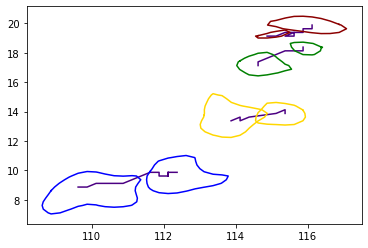

In [68]:
color = ['darkred', 'blue', 'green', 'gold']
for i in np.arange(4):
    
    id1, id2 = id_array_30[i].astype('int')
    traj = df.center_traj[eddy_30_id[i]][id1:id2+1, :]
    boun = df.boundary[eddy_30_id[i]]
    plt.plot(traj[:, 0], traj[:, 1], color='indigo')
    plt.plot(boun[id1][0, :], boun[id1][1, :], color=color[i])
    plt.plot(boun[id2][0, :], boun[id2][1, :], color=color[i])

In [ ]:
lev1 = np.arange(-1, 1.01, 0.02)

fig = plt.figure(figsize=(13, 16))

map_proj = ccrs.PlateCarree()

ax1 = plt.subplot(2, 2, 1, projection=map_proj)
ax1.add_feature(land_50m)
ax1.set_extent([99.9, 122, 2, 25.1], crs=map_proj)

ds_aviso.sel(longitude=slice(100, 130), latitude=slice(0, 28), time='2010-01-01').sla.plot.contour(levels=lev1, colors='k', linewidths=0.5)
color = ['orange', 'blue', 'darkgreen', 'maroon']
color2 = ['yellow', 'dodgerblue', 'springgreen', 'red']
label = ['Eddy A', 'Eddy B', 'Eddy C', 'Eddy D']
for i in np.arange(4):
    
    px = ds_new.x[0, :, :] * mask_array_30[i, :, :]
    py = ds_new.y[0, :, :] * mask_array_30[i, :, :]
    
    plt.scatter(px, py, s=3, color=color2[i])
    
    id1, id2 = id_array_30[i].astype('int')
    traj = df.center_traj[eddy_30_id[i]][id1:id2+1, :]
    boun = df.boundary[eddy_30_id[i]]
    plt.plot(boun[id1][0, :], boun[id1][1, :], color=color[i], linewidth=2, label=label[i])
    plt.plot(traj[:, 0], traj[:, 1], color='purple', linewidth=2)

plt.legend(loc=2)

tick_proj = ccrs.PlateCarree()
xvalues = np.arange(100, 125, 5)
yvalues = np.arange(0, 26, 5)

ax1.set_xticks(xvalues, crs=tick_proj)
ax1.set_yticks(yvalues, crs=tick_proj)

ax1.set_xticklabels(xvalues, fontsize=14)
ax1.set_yticklabels(yvalues, fontsize=14)

ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LongitudeFormatter())

plt.xlabel('')
plt.ylabel('')
plt.xlim(105, 122)
plt.ylim(3, 23)
plt.title('2010-01-01', size=16)

plt.text(105, 23.5, '(a)', size=18)

# -----------------------------

ax2 = plt.subplot(2, 2, 2, projection=map_proj)

ax2.add_feature(land_50m)
ax2.set_extent([99.9, 122, 2, 25.1], crs=map_proj)

ds_aviso.sel(longitude=slice(100, 130), latitude=slice(0, 28), time='2010-01-31').sla.plot.contour(levels=lev1, colors='k', linewidths=0.5)
for i in np.arange(4):
    px = ds_new.x[3, :, :] * mask_array_30[i, :, :]
    py = ds_new.y[3, :, :] * mask_array_30[i, :, :]
    
    plt.scatter(px, py, s=3, color=color2[i])
    
    id1, id2 = id_array_30[i].astype('int')
    traj = df.center_traj[eddy_30_id[i]][id1:id2+1, :]
    boun = df.boundary[eddy_30_id[i]]
    #plt.plot(boun[id1][0, :], boun[id1][1, :], color=color[i])
    plt.plot(boun[id2][0, :], boun[id2][1, :], color=color[i], linewidth=2)
    plt.plot(traj[:, 0], traj[:, 1], color='purple', linewidth=2)


tick_proj = ccrs.PlateCarree()
xvalues = np.arange(100, 125, 5)
yvalues = np.arange(0, 26, 5)

ax2.set_xticks(xvalues, crs=tick_proj)
ax2.set_yticks(yvalues, crs=tick_proj)

ax2.set_xticklabels(xvalues, fontsize=14)
ax2.set_yticklabels(yvalues, fontsize=14)

ax2.xaxis.set_major_formatter(LongitudeFormatter())
ax2.yaxis.set_major_formatter(LongitudeFormatter())

plt.xlabel('')
plt.ylabel('')
plt.xlim(105, 122)
plt.ylim(3, 23)
plt.title('2010-01-31', size=16)

plt.text(105, 23.5, '(b)', size=18)

# -----------------------------
label2 = ['Eddy E', 'Eddy F', 'Eddy G', 'Eddy H']
ax3 = plt.subplot(2, 2, 3, projection=map_proj)

ax3.add_feature(land_50m)
ax3.set_extent([99.9, 122, 2, 25.1], crs=map_proj)

ds_aviso.sel(longitude=slice(100, 130), latitude=slice(0, 28), time='2006-04-01').sla.plot.contour(levels=lev1, colors='k', linewidths=0.5)
for i in np.arange(4):
    px = ds_new2.x[0, :, :] * mask_array_60[i, :, :]
    py = ds_new2.y[0, :, :] * mask_array_60[i, :, :]
    
    plt.scatter(px, py, s=3, color=color2[i])
    
    id1, id2 = id_array_60[i].astype('int')
    traj = df.center_traj[eddy_60_id[i]][id1:id2+1, :]
    boun = df.boundary[eddy_60_id[i]]
    plt.plot(boun[id1][0, :], boun[id1][1, :], color=color[i], label=label2[i])
    #plt.plot(boun[id2][0, :], boun[id2][1, :], color=color[i], linewidth=2)
    plt.plot(traj[:, 0], traj[:, 1], color='purple', linewidth=2)

plt.legend(loc=2)
tick_proj = ccrs.PlateCarree()
xvalues = np.arange(100, 125, 5)
yvalues = np.arange(0, 26, 5)

ax3.set_xticks(xvalues, crs=tick_proj)
ax3.set_yticks(yvalues, crs=tick_proj)

ax3.set_xticklabels(xvalues, fontsize=14)
ax3.set_yticklabels(yvalues, fontsize=14)

ax3.xaxis.set_major_formatter(LongitudeFormatter())
ax3.yaxis.set_major_formatter(LongitudeFormatter())

plt.xlabel('')
plt.ylabel('')
plt.xlim(105, 122)
plt.ylim(3, 23)
plt.title('2006-04-01', size=16)

plt.text(105, 23.5, '(c)', size=18)

# -----------------------------

ax4 = plt.subplot(2, 2, 4, projection=map_proj)

ax4.add_feature(land_50m)
ax4.set_extent([99.9, 122, 2, 25.1], crs=map_proj)

ds_aviso.sel(longitude=slice(100, 130), latitude=slice(0, 28), time='2006-05-31').sla.plot.contour(levels=lev1, colors='k', linewidths=0.5)
for i in np.arange(4):
    px = ds_new2.x[6, :, :] * mask_array_60[i, :, :]
    py = ds_new2.y[6, :, :] * mask_array_60[i, :, :]
    
    plt.scatter(px, py, s=3, color=color2[i])
    
    id1, id2 = id_array_60[i].astype('int')
    traj = df.center_traj[eddy_60_id[i]][id1:id2+1, :]
    boun = df.boundary[eddy_60_id[i]]
    #plt.plot(boun[id1][0, :], boun[id1][1, :], color=color[i])
    plt.plot(boun[id2][0, :], boun[id2][1, :], color=color[i], linewidth=2)
    plt.plot(traj[:, 0], traj[:, 1], color='purple', linewidth=2)


tick_proj = ccrs.PlateCarree()
xvalues = np.arange(100, 125, 5)
yvalues = np.arange(0, 26, 5)

ax4.set_xticks(xvalues, crs=tick_proj)
ax4.set_yticks(yvalues, crs=tick_proj)

ax4.set_xticklabels(xvalues, fontsize=14)
ax4.set_yticklabels(yvalues, fontsize=14)

ax4.xaxis.set_major_formatter(LongitudeFormatter())
ax4.yaxis.set_major_formatter(LongitudeFormatter())

plt.xlabel('')
plt.ylabel('')
plt.xlim(105, 122)
plt.ylim(3, 23)
plt.title('2006-05-31', size=16)

plt.text(105, 23.5, '(d)', size=18)

plt.savefig('./figs/Figure_01.png', dpi=100)